# Worksheet 16

Name: Chao-Jen Chiu 

UID: U29089552

### Topics

- Support Vector Machines (Non-linear case)

## Support Vector Machines

Follow along in class to implement the perceptron algorithm and create an animation of the algorithm.

a) As we saw in class, the form
$$w^T x + b = 0$$
while simple, does not expose the inner product `<x_i, x_j>` which we know `w` depends on, having done the math. This is critical to applying the "kernel trick" which allows for learning non-linear decision boundaries. Let's modify the above algorithm to use the form
$$\sum_i \alpha_i <x_i, x> + b = 0$$

In [2]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

epochs = 100
learning_rate = .05
lr = learning_rate
expanding_rate = .99
retracting_rate = 1.1

X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

alpha_i = np.zeros((len(X),))
b = 0

def snap(x, alpha_i, b, error):
    # create a mesh to plot in
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y',fill=False))
   
    Z = predict_many(alpha_i, b, meshData)
    Z = np.array([0 if z <=0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def predict_many(alpha_i, b, Z):
    res = []
    for i in range(len(Z)):
        res.append(predict(alpha_i, b, Z[i]))
    return np.array(res)

def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

def predict(alpha_i, b, x):
    wx = 0
    for j in range(len(X)):
        wx += alpha_i[j] * polynomial(X[j], x, 1, 2)
    return wx + b

images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]
    ypred = predict(alpha_i, b, x)
    if (ypred > 0 and y > 0) or (ypred < 0 and y < 0):
        # classified correctly
        if 1 > ypred > -1:
            # in the street / street is too wide
            alpha_i[i] += y * lr
            alpha_i = alpha_i * retracting_rate
            b += y * lr * retracting_rate
        else:
            # street is too narrow
            alpha_i = alpha_i * expanding_rate
            b *= expanding_rate
    else:
        # misclassified
        alpha_i[i] += y * lr
        alpha_i = alpha_i * expanding_rate
        b += y * lr * expanding_rate
        
    images.append(snap(x, alpha_i, b, error))

images[0].save(
    'svm_dual.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

Write a configurable kernel function to apply in lieu of the dot product. Try it out on a dataset that is not linearly separable.

In [3]:
def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

def rbf(x_i, x_j, gamma):
    distance = np.linalg.norm(x_i - x_j) ** 2
    return np.exp(-gamma * distance)

b) Assume we fit an SVM using a polynomial Kernel function and it seems to overfit the data. How would you adjust the tuning parameter `n` of the kernel function?

Decrease the number of n so the function becomes less complex

c) Assume we fit an SVM using a RBF Kernel function and it seems to underfit the data. How would you adjust the tuning parameter `sigma` of the kernel function?

I would decrease sigma. Try to make the RBF kernel narrower, allowing the decision boundary to become more complex and fit more closely to the training data.

d) Tune the parameter of a specific Kernel function, to fit an SVM (using your code above) to the following dataset:

KeyboardInterrupt: 

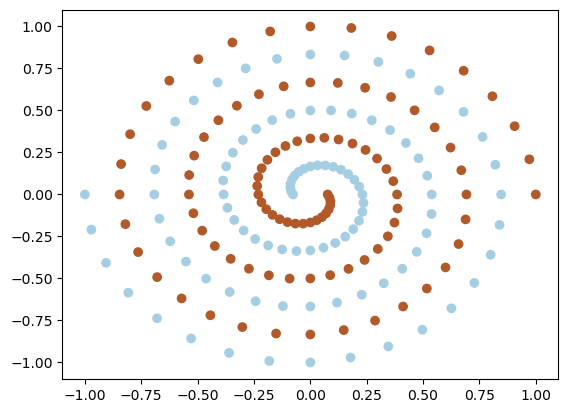

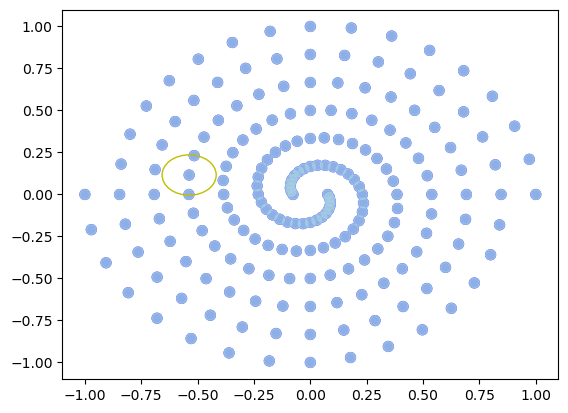

In [8]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("spiral.data")
x, y = data[:, :2], data[:, 2]

plt.scatter(x[:, 0], x[:, 1], c=y)

import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"

epochs = 100
learning_rate = .05
lr = learning_rate
expanding_rate = .99
retracting_rate = 1.1
X, labels = data[:, :2], data[:, 2]
labels = np.array([int(x) for x in labels])
Y = np.array(list(map(lambda x: -1 if x == 0 else 1, labels.tolist())))
alpha_i = np.zeros((len(X),))
b = 0


def snap(x, alpha_i, b, error):
    # create a mesh to plot in
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], color=cs[labels].tolist(), s=50, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, s=50, alpha=0.8)
    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r', fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y', fill=False))

    Z = predict_many(alpha_i, b, meshData)
    Z = np.array([0 if z <= 0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))


def predict_many(alpha_i, b, Z):
    res = []
    for i in range(len(Z)):
        res.append(predict(alpha_i, b, Z[i]))
    return np.array(res)


def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n


def rbf(x_i, x_j, gamma):
    distance = np.linalg.norm(x_i - x_j) ** 2
    return np.exp(-gamma * distance)


def predict(alpha_i, b, x):
    wx = 0
    for j in range(len(X)):
        wx += alpha_i[j] * rbf(X[j], x, 100)
    return wx + b


images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]
    ypred = predict(alpha_i, b, x)
    if (ypred > 0 and y > 0) or (ypred < 0 and y < 0):
        # classified correctly
        if 1 > ypred > -1:
            # in the street / street is too wide
            alpha_i[i] += y * lr
            alpha_i = alpha_i * retracting_rate
            b += y * lr * retracting_rate
        else:
            # street is too narrow
            alpha_i = alpha_i * expanding_rate
            b *= expanding_rate
    else:
        # misclassified
        alpha_i[i] += y * lr
        alpha_i = alpha_i * expanding_rate
        b += y * lr * expanding_rate

    images.append(snap(x, alpha_i, b, error))

images[0].save(
    'svm_dual.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

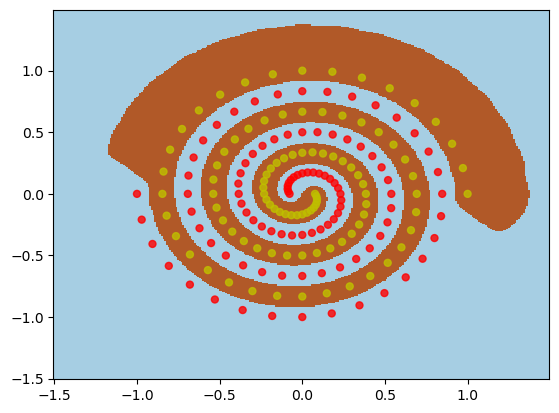

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

f = np.loadtxt("spiral.data")
x, y = f[:, :2], f[:, 2]
m = svm.SVC(kernel='rbf', gamma=100)
m.fit(x, y)

h = .01  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
xnew = np.c_[xx.ravel(), yy.ravel()]
ynew = m.predict(xnew).reshape(xx.shape)
fig = plt.figure(1)
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, ynew)
plt.scatter(x[:, 0], x[:, 1], c=y)
cs = np.array([x for x in 'ryr'])
plt.scatter(X[:, 0], X[:, 1], color=cs[labels].tolist(), s=25, alpha=0.8)
plt.show()